In [1]:
import os
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import albumentations
import albumentations.pytorch
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader 
from PIL import Image 
import cv2   #albumentation transform을 쓰려면 꼭 이 라이브러리를 이용

In [2]:
Dataset_path = './dataset'

train_path = './dataset/train'
test_path = './dataset//test'

cat_dir = '/cat/'
dog_dir = '/dog/'

In [3]:
class Custom_Dataset(Dataset):

    def __init__(self, file_path, mode, transform=None):
        self.all_data = sorted(glob.glob(os.path.join(file_path, mode, '*', '*')))
        self.transform = transform

    def __getitem__(self, index):

        if torch.is_tensor(index):        # 인덱스가 tensor 형태일 수 있으니 리스트 형태로 바꿔줌
            index = index.tolist()

        data_path = self.all_data[index]
        #img = np.array(Image.open(data_path).convert("RGB")) # albumenatation transform을 쓰려면 cv2 라이브러리로 이미지를 읽어야 함
        image=cv2.imread(data_path)
        image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB 변환

        # transform 적용
        if self.transform is not None:    
            augmented = self.transform(image=image)
            image = augmented['image'] 

        # 이미지 이름을 활용해 label 부여
        label=[]                                
        if os.path.basename(data_path).startswith("cat") == True:
            label = 0
        else :
            label = 1
        return image, label

    def __len__(self):
        length = len(self.all_data)
        return length

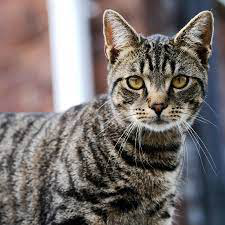

In [4]:
Image.open(Custom_Dataset(Dataset_path,'train', transform = None).all_data[0])

## albumentation 이용하여 데이터 전처리 

In [5]:
import albumentations
import albumentations.pytorch

In [39]:
albumentations_resize = albumentations.Compose([                                                
    albumentations.Resize(128, 128), 
    # albumentations.Normalize(),
    albumentations.pytorch.transforms.ToTensorV2()
])

resize_train=Custom_Dataset(Dataset_path, 'train', transform=albumentations_resize)
resize_test=Custom_Dataset(Dataset_path, 'test', transform=albumentations_resize)

*데이터 클래스를 거쳐 나온 이미지 데이터 -> 텐서 형태  
시각화를 위해 [height, width, channels] 형태로 배열을 다시 바꿔줘야함*

In [40]:
def tensor_img(img):    
    img = img.permute(1,2,0)
    plt.imshow(img)

In [41]:
resize_train[100][0].shape

torch.Size([3, 128, 128])

In [42]:
resize_train[100][0].permute(1,2,0).shape

torch.Size([128, 128, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


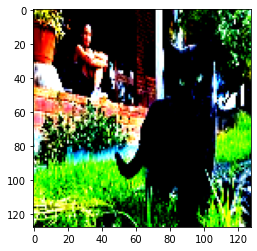

In [43]:
# 128 x 128 변환 확인
tensor_img(resize_train[100][0])

In [44]:
resize_train[100][0]

tensor([[[-0.8849,  1.1872,  0.2796,  ...,  0.2282, -0.2684,  0.7933],
         [-0.2171,  1.2043,  0.8447,  ...,  0.0741,  0.5022,  0.8276],
         [ 0.5193,  0.8104,  0.3309,  ...,  0.1597,  0.5707,  0.6049],
         ...,
         [ 1.1358,  0.3481, -0.3198,  ..., -0.0287, -0.6965, -1.2274],
         [ 0.4679, -0.5082, -0.5424,  ..., -0.2342, -1.0390, -1.8097],
         [-0.4911, -0.8335, -0.2342,  ..., -0.5253, -1.1932, -1.9980]],

        [[-0.8803,  1.2031,  0.2752,  ...,  0.7829,  0.4678,  1.7108],
         [-0.1625,  1.2906,  0.9055,  ...,  0.6429,  1.2381,  1.7108],
         [ 0.6429,  0.9230,  0.4678,  ...,  0.7479,  1.2731,  1.4307],
         ...,
         [ 1.6933,  0.7479,  0.0476,  ...,  0.2052, -0.4251, -0.9503],
         [ 1.0105, -0.1275, -0.1800,  ..., -0.0049, -0.7402, -1.5105],
         [ 0.0476, -0.4601,  0.1352,  ..., -0.3025, -0.8978, -1.7206]],

        [[-1.6476,  0.3916, -0.5844,  ...,  0.2522, -0.0092,  1.5071],
         [-0.8807,  0.4614,  0.0605,  ...,  0

## normalization 준비 

In [45]:
def get_mean_std(dataset):
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print(meanR, meanG, meanB)
    print(stdR, stdG, stdB)

In [46]:
get_mean_std(resize_train)

0.40978363 0.4007882 0.3502374
0.96983695 0.98876435 1.0378909


In [47]:
get_mean_std(resize_test)

0.44379672 0.42892647 0.35995993
0.9604247 0.98791337 1.0178185


In [48]:
resize_train_mean=[147.60466885501393, 139.17329870772687, 123.62458596425513]
resize_train_std=[56.6336324643294, 56.47825139969121, 59.54909624954104]

resize_test_mean=[149.59144600623293, 140.78101819981643, 124.18209255197661]
resize_test_std=[56.08399892325943, 56.429601804462806, 58.397342551928666]

In [16]:
# transform 이용시 평균과, 표준편차
# resize_train_mean=[0.57926023, 0.54618114, 0.48523054]
# resize_train_std=[0.21845086, 0.21776533, 0.23011613]

# resize_test_mean=[0.587039, 0.5524677, 0.4874089]
# resize_test_std=[0.21670184, 0.21802938, 0.22591734]

정규화 시,  
- mean, std 값이 (0,255) 사이 : max_pixel_value=1.0  
- mean, std 값이 (-1,1) 사이 : max_pixel_value=255

## albumentation 이용하여 data augmentation 

In [17]:
import albumentations
import albumentations.pytorch
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
from albumentations.pytorch import ToTensorV2

In [33]:
albumentations_train = albumentations.Compose([
    
    albumentations.Resize(128, 128),
    
    # 3X3=9가지의 조합가능
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=0.8), # p확률로 이미지 좌우 반전
                          albumentations.RandomRotate90(p=0.8), # p확률로 90도 회전
                          albumentations.VerticalFlip(p=0.8) # p확률로 이미지 상하 반전
    ], p=1),

    albumentations.OneOf([
                          albumentations.MotionBlur(p=0.8), # p확률로 이미지를 흐리게(?) 만들어 줌
                          albumentations.OpticalDistortion(p=0.8), # p확률로 이미지 왜곡
                          albumentations.GaussNoise(p=0.8) # 임의의 noise를 삽입          
    ], p=1),
    albumentations.Normalize(mean = resize_train_mean, std = resize_train_std, max_pixel_value=1.0),
    albumentations.pytorch.ToTensorV2() ## 정규화 내장?
    
])

albumentations_test = albumentations.Compose([
                                                
    albumentations.Resize(128, 128),
    albumentations.pytorch.ToTensorV2()
    
])


trainset=inhovation_Dataset(Dataset_path, 'train', transform=albumentations_train)
testset=inhovation_Dataset(Dataset_path, 'test', transform=albumentations_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0)

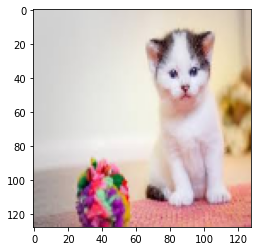

In [36]:
plt.imshow(resize_train[200][0].permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


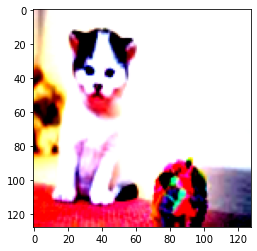

In [37]:
tensor_img(trainset[200][0])

In [38]:
trainset[200][0]

tensor([[[-0.4345, -0.3285, -0.4345,  ...,  1.1194,  1.1900,  1.3313],
         [-0.2226, -0.4874, -0.2226,  ...,  0.6956,  0.8545,  0.9605],
         [-0.4345, -0.3109, -0.4345,  ...,  1.1194,  1.1547,  1.3489],
         ...,
         [ 1.0841,  1.0841,  1.0841,  ...,  1.0134,  0.9958,  0.9605],
         [ 1.0841,  1.0841,  1.0841,  ...,  1.0134,  1.0134,  0.9781],
         [ 1.0841,  1.0841,  1.0841,  ...,  1.0311,  1.0134,  0.9781]],

        [[-0.5165, -0.4103, -0.4988,  ..., -0.3395, -0.3218, -0.2155],
         [-0.2864, -0.5520, -0.2864,  ..., -0.7821, -0.7113, -0.6228],
         [-0.4988, -0.3749, -0.4988,  ..., -0.3395, -0.3395, -0.2155],
         ...,
         [ 1.2363,  1.2363,  1.2363,  ...,  0.8468,  0.8291,  0.7937],
         [ 1.2363,  1.2363,  1.2363,  ...,  0.8468,  0.8468,  0.8114],
         [ 1.2363,  1.2363,  1.2363,  ...,  0.8645,  0.8468,  0.8114]],

        [[-0.2288, -0.1280, -0.2120,  ...,  0.0903,  0.1406,  0.2246],
         [-0.0105, -0.2624, -0.0105,  ..., -0